<a href="https://colab.research.google.com/github/Sistemas-Multimedia/Sistemas-Multimedia.github.io/blob/master/milestones/04-the_data/display_video.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Practica Equipo 3

In [106]:
%matplotlib inline

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.axes as ax
plt.rcParams['text.usetex'] = True
#plt.rcParams['text.latex.preamble'] = [r'\usepackage{amsmath}'] #for \text command

import pylab
import math
import numpy as np
from scipy import signal
import cv2
import os


import pywt
import pylab

In [110]:
def normalize(img):
    max_component = np.max(img)
    min_component = np.min(img)
    max_min_component = max_component - min_component
    return (img-min_component)/max_min_component

def load_img(prefix):
    img = cv2.imread(f"{prefix}.png", cv2.IMREAD_UNCHANGED)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = np.array(img)
    img = img.astype(np.float32) - 32768.0
    return img

def show_img(prefix):
    img = load_img(prefix)
    img = normalize(img)
    plt.figure(figsize=(10,10))
    plt.title(prefix, fontsize=20)
    plt.imshow(img)



def show_motion(prefix="/tmp/", frames=5):
    plt.figure(figsize=(10,10))
    prev = load_img(f"{prefix}000")
    imgplot = plt.imshow(normalize(prev))
    for i in range(1, frames, 1):
        img = load_img(f"{prefix}{i:03d}")
        diff = img - prev
        prev = img
        diff = normalize(diff)
        plt.figure(figsize=(10,10))
        plt.title(f"{prefix}{i:03d}", fontsize=20)
        plt.imshow(diff)
        
        
def quantizer(x, quantization_step):
    k = (x / quantization_step).astype(np.int16)
    return k

def dequantizer(k, quantization_step):
    y = quantization_step * k
    return y

def q_deq(x, quantization_step):
    k = quantizer(x, quantization_step)
    y = dequantizer(k, quantization_step)
    return k, y

# Notice that the dead-zone to have effect,
# the samples should be allowed to negative.


def load_frame(prefix):
    fn = f"{prefix}.png"
    frame = cv2.imread(fn, cv2.IMREAD_UNCHANGED) # [rows, cols, comp]
    frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    frame = np.array(frame)
    frame = frame.astype(np.float32) - 32768.0
    frame = frame.astype(np.int16)
    return frame

def write_frame(frame, prefix):
    frame = frame.astype(np.float32)
    frame += 32768.0
    frame = frame.astype(np.uint16)
    cv2.imwrite(f"{prefix}.png", frame)

def load_indexes(prefix):
    load_frame(prefix)
    
def write_indexes(prefix):
    write_frame(prefix)
    
    
def RGB_to_YCoCg(RGB_frame):
    R, G, B = RGB_frame[:,:,0], RGB_frame[:,:,1], RGB_frame[:,:,2]
    YCoCg_frame = np.empty_like(RGB_frame)
    YCoCg_frame[:,:,0] =  R/4 + G/2 + B/4 
    YCoCg_frame[:,:,1] =  R/2       - B/2
    YCoCg_frame[:,:,2] = -R/4 + G/2 - B/4
    return YCoCg_frame

def YCoCg_to_RGB(YCoCg_frame):
    Y, Co, Cg = YCoCg_frame[:,:,0], YCoCg_frame[:,:,1], YCoCg_frame[:,:,2]
    RGB_frame = np.empty_like(YCoCg_frame)
    RGB_frame[:,:,0] = Y + Co - Cg 
    RGB_frame[:,:,1] = Y      + Cg
    RGB_frame[:,:,2] = Y - Co - Cg
    return RGB_frame    



def average_energy(x):
    return np.sum(x.astype(np.double)*x.astype(np.double))/len(x)



WAVELET = pywt.Wavelet("db5")
#WAVELET = pywt.Wavelet("bior3.5")
N_LEVELS = 3

def color_DWT_analyze(color_frame, wavelet=WAVELET, n_levels=N_LEVELS):
    n_channels = color_frame.shape[2]
    color_decomposition = [None]*n_channels
    for c in range(n_channels):
        color_decomposition[c] = pywt.wavedec2(data=color_frame[:,:,c], wavelet=wavelet, mode='per', level=n_levels)
    return color_decomposition # A list of "gray" decompositions

def color_DWT_synthesize(color_decomposition, wavelet=WAVELET):
    n_channels = len(color_decomposition)
    #n_levels = len(color_decomposition[0])-1
    # color_decomposition[0] <- First channel
    # color_decomposition[0][0] <- cAn (lowest frequecy subband) of the first channel
    # color_decomposition[0][1] <- (cHn, cVn, cDn) (lowest high-frequency subbands) of the first channel
    # color_decomposition[0][1][0] <- cHn (LH subband) of the first channel
    # See https://pywavelets.readthedocs.io/en/latest/ref/2d-dwt-and-idwt.html#d-multilevel-decomposition-using-wavedec2
    _color_frame = []
    for c in range(n_channels):
        frame = pywt.waverec2(color_decomposition[c], wavelet=wavelet, mode='per')
        _color_frame.append(frame)
    n_rows = _color_frame[0].shape[0]
    n_columns = _color_frame[0].shape[1]
    color_frame = np.ndarray((n_rows, n_columns, n_channels), np.float64)
    for c in range(n_channels):
        color_frame[:,:,c] = _color_frame[c][:,:]
    return color_frame
                    
                    
                    
                    

def show_seq(prefix="/tmp/", frames=5):
    for i in range(frames):
        fichero=f"{prefix}{i:03d}"
        print (fichero)
        #show_img(fichero)
        
        R_energy = average_energy(frame[:,:,0])
        G_energy = average_energy(frame[:,:,1])
        B_energy = average_energy(frame[:,:,2])
        print("Energy of R =", R_energy)
        print("Energy of G =", G_energy)
        print("Energy of B =", B_energy)
        
        YCoCg = RGB_to_YCoCg(frame)
        frame2 = YCoCg_to_RGB(YCoCg)
       
       #show_img(frame2)      ##### daria error  por no ser RGB
        Y_energy = average_energy(YCoCg[:,:,0])
        Co_energy = average_energy(YCoCg[:,:,1])
        Cg_energy = average_energy(YCoCg[:,:,2])
        print("Energy of Y =", Y_energy)
        print("Energy of Co =", Co_energy)
        print("Energy of Cg =", Cg_energy)
        
        #DWT
        YCoCg_decomposition = color_DWT_analyze(frame2, n_levels=2)
        reconstructed_YCoCg_frame = color_DWT_synthesize(YCoCg_decomposition)
        #reconstructed_RGB_frame = YCoCg_to_RGB(reconstructed_YCoCg_frame)
        #assert frame2.all() == reconstructed_RGB_frame.all()             
                    

        



In [111]:
show_seq("/home/soloelectronicos/MRVC/sequences/stockholm/") # <- Your path here!

/home/soloelectronicos/MRVC/sequences/stockholm/000
Energy of R = 16031572.591145834
Energy of G = 12341191.74609375
Energy of B = 9893899.2890625
Energy of Y = 12413817.684895834
Energy of Co = 307893.3020833333
Energy of Cg = 6258.272135416667
/home/soloelectronicos/MRVC/sequences/stockholm/001
Energy of R = 16031572.591145834
Energy of G = 12341191.74609375
Energy of B = 9893899.2890625
Energy of Y = 12413817.684895834
Energy of Co = 307893.3020833333
Energy of Cg = 6258.272135416667
/home/soloelectronicos/MRVC/sequences/stockholm/002
Energy of R = 16031572.591145834
Energy of G = 12341191.74609375
Energy of B = 9893899.2890625
Energy of Y = 12413817.684895834
Energy of Co = 307893.3020833333
Energy of Cg = 6258.272135416667
/home/soloelectronicos/MRVC/sequences/stockholm/003
Energy of R = 16031572.591145834
Energy of G = 12341191.74609375
Energy of B = 9893899.2890625
Energy of Y = 12413817.684895834
Energy of Co = 307893.3020833333
Energy of Cg = 6258.272135416667
/home/soloelectr

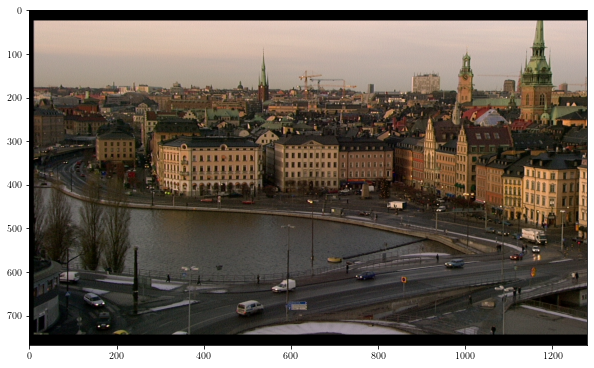

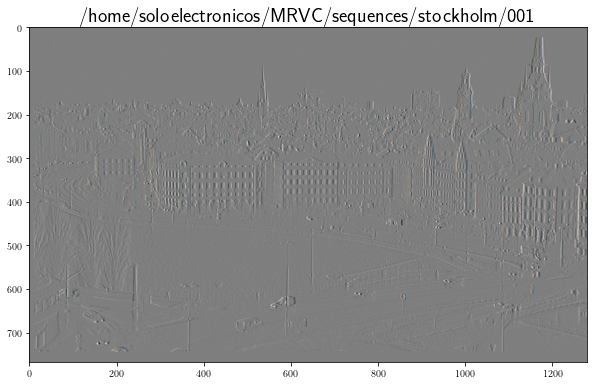

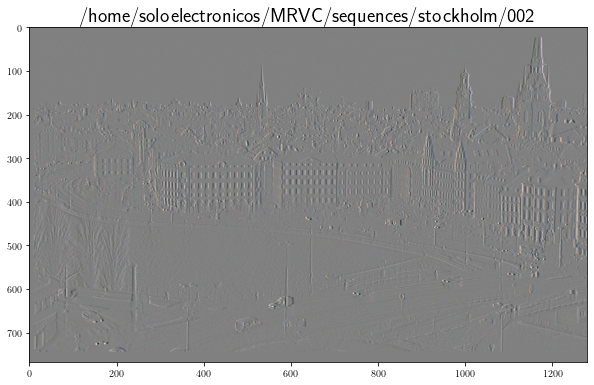

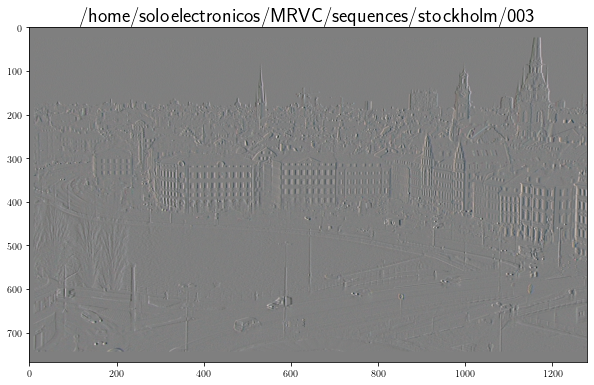

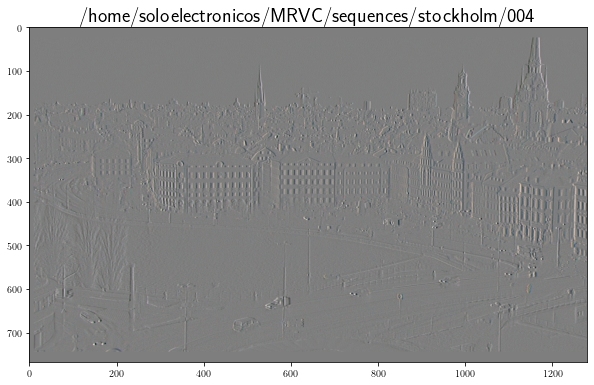

In [112]:
show_motion("/home/soloelectronicos/MRVC/sequences/stockholm/") # <- Your path here!